In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet

In [ ]:
data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/Data%20Sets%20Time%20Series%20Analysis/Time%20Series%20-%20Day%204/MSFT_data.csv')
data['date'] = pd.to_datetime(data['date'])

train = data.iloc[:-30]
test = data.iloc[-30:]

In [ ]:
data.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.35,27.71,27.31,27.55,33318306,MSFT
1,2013-02-11,27.65,27.92,27.50,27.86,32247549,MSFT
2,2013-02-12,27.88,28.00,27.75,27.88,35990829,MSFT
3,2013-02-13,27.93,28.11,27.88,28.03,41715530,MSFT
4,2013-02-14,27.92,28.06,27.87,28.04,32663174,MSFT


In [ ]:
train.tail()

,date,open,high,low,close,volume,Name
1224,2017-12-18,87.12,87.4999,86.23,86.38,22283752,MSFT
1225,2017-12-19,86.35,86.3500,85.27,85.83,23524787,MSFT
1226,2017-12-20,86.20,86.3000,84.71,85.52,23674931,MSFT
1227,2017-12-21,86.05,86.1000,85.40,85.50,17990745,MSFT
1228,2017-12-22,85.40,85.6300,84.92,85.51,14145841,MSFT


In [ ]:
test.head()

,date,open,high,low,close,volume,Name
1229,2017-12-26,85.310,85.5346,85.030,85.40,9891237,MSFT
1230,2017-12-27,85.650,85.9800,85.215,85.71,14678025,MSFT
1231,2017-12-28,85.900,85.9300,85.550,85.72,10594344,MSFT
1232,2017-12-29,85.630,86.0500,85.500,85.54,18717406,MSFT
1233,2018-01-02,86.125,86.3100,85.500,85.95,22483797,MSFT


In [ ]:
def ilinechart(df, x, y, groups=None, title=''):
    fig = px.line(df, x=x, y=y, color=groups, title=title, 
                  template='none')
    
    fig.show()

In [ ]:
ilinechart(data, 'date', 'close', title='Observations over time')

In [ ]:
# time series decomposition
series = train[['date', 'close']].set_index('date')
decomposition = sm.tsa.seasonal_decompose(series, model='additive', freq=252)

In [ ]:
# extract the decomposed components
trend = decomposition.trend.reset_index()
seasonality = decomposition.seasonal.reset_index()
residuals = decomposition.resid.reset_index()

In [ ]:
merged = series.merge(trend, on='date')
merged = merged.merge(seasonality, on='date')
merged = merged.merge(residuals, on='date')
merged.columns = ['date', 'observed', 'trend', 'seasonality', 'residuals']

In [ ]:
# merged.rename()

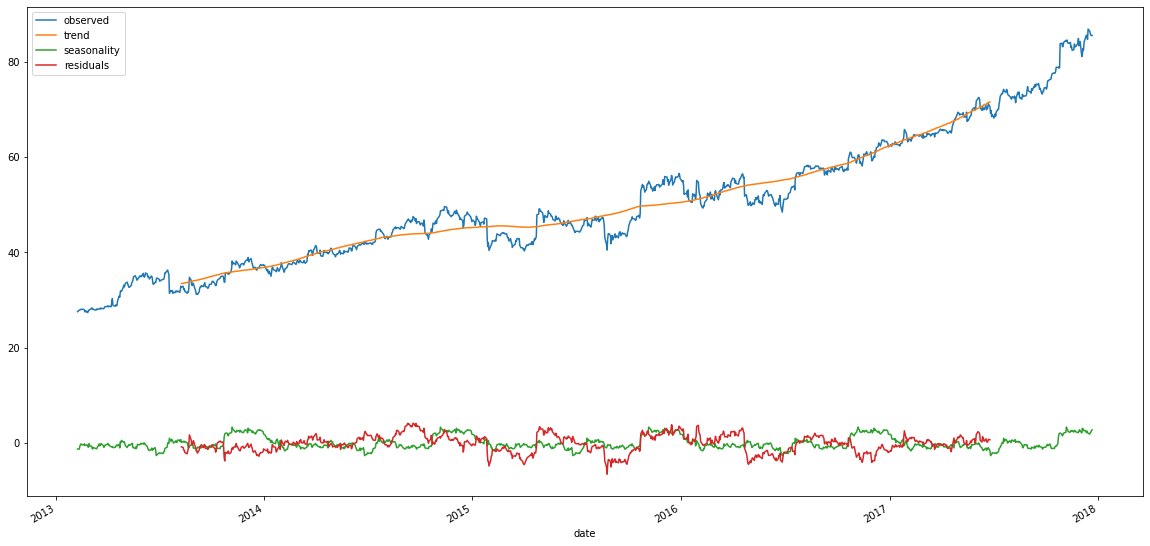

In [ ]:
merged.set_index('date').plot(kind='line', figsize=(20,10))

In [ ]:
# single exponential smoothing
model = sm.tsa.ExponentialSmoothing(merged['observed']).fit()
single_exp = model.forecast(30) # forecast 30 out-of-sample timesteps

In [ ]:
# double exponential smoothing
model = sm.tsa.ExponentialSmoothing(merged['observed'], trend='additive').fit()
double_exp = model.forecast(30)

In [ ]:
# triple exponential smoothing
model = sm.tsa.ExponentialSmoothing(merged['observed'], trend='additive', 
                                    seasonal='additive', seasonal_periods=4).fit()
triple_exp = model.forecast(30)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [ ]:
triple_exp

In [ ]:
def forecast(data, field, model, periods):
    model_results = model.forecast(periods)[0]
    current_value = data[field].iloc[-1]
    forecasts = []
    
    for result in model_results:
        forecast = current_value + result
        forecasts.append(forecast)
        current_value = forecast
    
    forecasts = pd.Series(forecasts)
    forecasts.index = [x + periods 
                       for x in list(data[field].tail(periods).index)]
    
    return forecasts

In [ ]:
data.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.35,27.71,27.31,27.55,33318306,MSFT
1,2013-02-11,27.65,27.92,27.50,27.86,32247549,MSFT
2,2013-02-12,27.88,28.00,27.75,27.88,35990829,MSFT
3,2013-02-13,27.93,28.11,27.88,28.03,41715530,MSFT
4,2013-02-14,27.92,28.06,27.87,28.04,32663174,MSFT


In [ ]:
train['Shift'] = train['close'].shift(1).fillna(method='bfill')
train['Diff'] = train['close'] - train['Shift']
train.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,date,open,high,low,close,volume,Name,Shift,Diff
0,2013-02-08,27.35,27.71,27.31,27.55,33318306,MSFT,27.55,0.00
1,2013-02-11,27.65,27.92,27.50,27.86,32247549,MSFT,27.55,0.31
2,2013-02-12,27.88,28.00,27.75,27.88,35990829,MSFT,27.86,0.02
3,2013-02-13,27.93,28.11,27.88,28.03,41715530,MSFT,27.88,0.15
4,2013-02-14,27.92,28.06,27.87,28.04,32663174,MSFT,28.03,0.01


In [ ]:
model = ARMA(train['Diff'], order=(2,1)).fit()
arma_forecasts = forecast(train, 'close', model, 30)
arma_forecasts.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning:

overflow encountered in exp

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning:

invalid value encountered in true_divide



1229    85.539358
1230    85.571416
1231    85.605491
1232    85.641304
1233    85.678622
dtype: float64

In [ ]:
# ARIMA
# model = ARIMA(data['Diff'], order=(1,1,1)).fit()
# arima_forecasts = forecast(data, 'close', model, 30)
model = SARIMAX(train['close'], order=(1,1,1), seasonal_order=(0,0,0,0)).fit()
arima_forecasts = model.forecast(30)
arima_forecasts.head()

1229    85.499576
1230    85.490953
1231    85.483822
1232    85.477924
1233    85.473045
dtype: float64

In [ ]:
model = SARIMAX(train['close'], order=(2,1,1), seasonal_order=(1,1,1,4)).fit() # seasonal_order = (p, d, q, s)
sarima_forecasts = model.forecast(30)
sarima_forecasts.head(20)

1229    85.580419
1230    85.547352
1231    85.577081
1232    85.655389
1233    85.736046
1234    85.709133
1235    85.743128
1236    85.825170
1237    85.908750
1238    85.884296
1239    85.920366
1240    86.004161
1241    86.089223
1242    86.066022
1243    86.103151
1244    86.187841
1245    86.273660
1246    86.251099
1247    86.288768
1248    86.373916
dtype: float64

In [ ]:
series = train[['date', 'close']]
series.columns = ['ds', 'y']
series

,ds,y
0,2013-02-08,27.55
1,2013-02-11,27.86
2,2013-02-12,27.88
3,2013-02-13,28.03
4,2013-02-14,28.04
...,...,...
1224,2017-12-18,86.38
1225,2017-12-19,85.83
1226,2017-12-20,85.52
1227,2017-12-21,85.50


In [ ]:
# FB Prophet
model = Prophet()
model.fit(series)

future = model.make_future_dataframe(30)
future

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
0,2013-02-08
1,2013-02-11
2,2013-02-12
3,2013-02-13
4,2013-02-14
...,...
1254,2018-01-17
1255,2018-01-18
1256,2018-01-19
1257,2018-01-20


In [ ]:
series.tail()

,ds,y
1224,2017-12-18,86.38
1225,2017-12-19,85.83
1226,2017-12-20,85.52
1227,2017-12-21,85.50
1228,2017-12-22,85.51


In [ ]:
results = model.predict(future)
results.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-02-08,27.169461,24.938694,28.633099,27.169461,27.169461,-0.323929,-0.323929,-0.323929,0.005034,0.005034,0.005034,-0.328963,-0.328963,-0.328963,0.0,0.0,0.0,26.845533
1,2013-02-11,27.355317,25.155509,29.123051,27.355317,27.355317,-0.306908,-0.306908,-0.306908,-0.042990,-0.042990,-0.042990,-0.263917,-0.263917,-0.263917,0.0,0.0,0.0,27.048409
2,2013-02-12,27.417269,25.190238,28.863729,27.417269,27.417269,-0.323154,-0.323154,-0.323154,-0.081749,-0.081749,-0.081749,-0.241404,-0.241404,-0.241404,0.0,0.0,0.0,27.094115
3,2013-02-13,27.479221,25.133251,29.042157,27.479221,27.479221,-0.283928,-0.283928,-0.283928,-0.063758,-0.063758,-0.063758,-0.220170,-0.220170,-0.220170,0.0,0.0,0.0,27.195293
4,2013-02-14,27.541172,25.377558,29.143312,27.541172,27.541172,-0.302097,-0.302097,-0.302097,-0.100934,-0.100934,-0.100934,-0.201162,-0.201162,-0.201162,0.0,0.0,0.0,27.239076


In [ ]:
results.tail(40)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1219,2017-12-11,81.705546,82.705324,86.549047,81.705546,81.705546,2.838375,2.838375,2.838375,-0.042990,-0.042990,-0.042990,2.881365,2.881365,2.881365,0.0,0.0,0.0,84.543921
1220,2017-12-12,81.765719,82.795496,86.441863,81.765719,81.765719,2.830481,2.830481,2.830481,-0.081749,-0.081749,-0.081749,2.912230,2.912230,2.912230,0.0,0.0,0.0,84.596200
1221,2017-12-13,81.825893,82.844555,86.369621,81.825893,81.825893,2.871988,2.871988,2.871988,-0.063758,-0.063758,-0.063758,2.935746,2.935746,2.935746,0.0,0.0,0.0,84.697881
1222,2017-12-14,81.886066,82.941080,86.516135,81.886066,81.886066,2.850315,2.850315,2.850315,-0.100934,-0.100934,-0.100934,2.951250,2.951250,2.951250,0.0,0.0,0.0,84.736381
1223,2017-12-15,81.946239,83.127464,86.715150,81.946239,81.946239,2.963302,2.963302,2.963302,0.005034,0.005034,0.005034,2.958269,2.958269,2.958269,0.0,0.0,0.0,84.909541
1224,2017-12-18,82.126758,83.167815,86.954484,82.126758,82.126758,2.883591,2.883591,2.883591,-0.042990,-0.042990,-0.042990,2.926581,2.926581,2.926581,0.0,0.0,0.0,85.010349
1225,2017-12-19,82.186931,83.116524,86.942988,82.186931,82.186931,2.816973,2.816973,2.816973,-0.081749,-0.081749,-0.081749,2.898722,2.898722,2.898722,0.0,0.0,0.0,85.003904
1226,2017-12-20,82.247104,83.006578,86.854846,82.247104,82.247104,2.798997,2.798997,2.798997,-0.063758,-0.063758,-0.063758,2.862755,2.862755,2.862755,0.0,0.0,0.0,85.046102
1227,2017-12-21,82.307278,83.232175,86.849266,82.307278,82.307278,2.718267,2.718267,2.718267,-0.100934,-0.100934,-0.100934,2.819201,2.819201,2.819201,0.0,0.0,0.0,85.025544
1228,2017-12-22,82.367451,83.321657,87.117970,82.367451,82.367451,2.773714,2.773714,2.773714,0.005034,0.005034,0.005034,2.768680,2.768680,2.768680,0.0,0.0,0.0,85.141165


In [ ]:
prophet_forecasts = results.iloc[-30:]['yhat']
prophet_forecasts

1229    85.281708
1230    85.279550
1231    85.087426
1232    85.037711
1233    85.041451
1234    84.987407
1235    85.074506
1236    85.191334
1237    85.169976
1238    84.962759
1239    84.901561
1240    84.896867
1241    84.836837
1242    84.919789
1243    85.033716
1244    85.010152
1245    84.800938
1246    84.737546
1247    84.730160
1248    84.666748
1249    84.745552
1250    84.854612
1251    84.825622
1252    84.610696
1253    84.541677
1254    84.529199
1255    84.461744
1256    84.538109
1257    84.646906
1258    84.620394
Name: yhat, dtype: float64

In [ ]:
future_dates = pd.DataFrame({'date': pd.date_range(start=train.date.iloc[-1], periods=31, freq='D', closed='right')})

len(future_dates)

30

In [ ]:
future_dates.head()

,date
0,2017-12-23
1,2017-12-24
2,2017-12-25
3,2017-12-26
4,2017-12-27


In [ ]:
fcast_df = pd.concat([pd.DataFrame(train['date']), future_dates], ignore_index=True)
fcast_df = fcast_df.merge(train[['date', 'close']], on='date', how='left')
fcast_df

,date,close
0,2013-02-08,27.55
1,2013-02-11,27.86
2,2013-02-12,27.88
3,2013-02-13,28.03
4,2013-02-14,28.04
...,...,...
1254,2018-01-17,NaN
1255,2018-01-18,NaN
1256,2018-01-19,NaN
1257,2018-01-20,NaN


In [ ]:
fcast_df.tail(35)

,date,close
1224,2017-12-18,86.38
1225,2017-12-19,85.83
1226,2017-12-20,85.52
1227,2017-12-21,85.50
1228,2017-12-22,85.51
1229,2017-12-23,NaN
1230,2017-12-24,NaN
1231,2017-12-25,NaN
1232,2017-12-26,NaN
1233,2017-12-27,NaN


In [ ]:
fcast_df['Double_Exp_Smooth'] = double_exp
fcast_df['Triple_Exp_Smooth'] = triple_exp
fcast_df['ARMA'] = arma_forecasts
fcast_df['ARIMA'] = arima_forecasts
fcast_df['SARIMA'] = sarima_forecasts
fcast_df['Prophet'] = prophet_forecasts

fcast_df.head()

,date,close,Double_Exp_Smooth,Triple_Exp_Smooth,ARMA,ARIMA,SARIMA,Prophet
0,2013-02-08,27.55,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-02-11,27.86,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-02-12,27.88,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-02-13,28.03,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-02-14,28.04,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
fcast_df.tail(35)

,date,close,Double_Exp_Smooth,Triple_Exp_Smooth,ARMA,ARIMA,SARIMA,Prophet
1224,2017-12-18,86.38,NaN,NaN,NaN,NaN,NaN,NaN
1225,2017-12-19,85.83,NaN,NaN,NaN,NaN,NaN,NaN
1226,2017-12-20,85.52,NaN,NaN,NaN,NaN,NaN,NaN
1227,2017-12-21,85.50,NaN,NaN,NaN,NaN,NaN,NaN
1228,2017-12-22,85.51,NaN,NaN,NaN,NaN,NaN,NaN
1229,2017-12-23,NaN,85.557643,85.799096,85.539358,85.499576,85.580419,85.281708
1230,2017-12-24,NaN,85.604842,85.760607,85.571416,85.490953,85.547352,85.279550
1231,2017-12-25,NaN,85.652040,85.908405,85.605491,85.483822,85.577081,85.087426
1232,2017-12-26,NaN,85.699239,85.980973,85.641304,85.477924,85.655389,85.037711
1233,2017-12-27,NaN,85.746438,86.266609,85.678622,85.473045,85.736046,85.041451


In [ ]:
melted = pd.melt(fcast_df, id_vars='date', value_vars=fcast_df.columns[1:])

melted.head()

,date,variable,value
0,2013-02-08,close,27.55
1,2013-02-11,close,27.86
2,2013-02-12,close,27.88
3,2013-02-13,close,28.03
4,2013-02-14,close,28.04


In [ ]:
ilinechart(melted, 'date', 'value', groups='variable', title='Forecast comparisons')

In [ ]:
fcast_df.tail(30)

,date,close,Double_Exp_Smooth,Triple_Exp_Smooth,ARMA,ARIMA,SARIMA,Prophet
1229,2017-12-23,NaN,85.557643,85.799096,85.539358,85.499576,85.580419,85.281708
1230,2017-12-24,NaN,85.604842,85.760607,85.571416,85.490953,85.547352,85.279550
1231,2017-12-25,NaN,85.652040,85.908405,85.605491,85.483822,85.577081,85.087426
1232,2017-12-26,NaN,85.699239,85.980973,85.641304,85.477924,85.655389,85.037711
1233,2017-12-27,NaN,85.746438,86.266609,85.678622,85.473045,85.736046,85.041451
1234,2017-12-28,NaN,85.793637,86.228120,85.717246,85.469010,85.709133,84.987407
1235,2017-12-29,NaN,85.840836,86.375918,85.757000,85.465672,85.743128,85.074506
1236,2017-12-30,NaN,85.888034,86.448486,85.797734,85.462912,85.825170,85.191334
1237,2017-12-31,NaN,85.935233,86.734121,85.839315,85.460628,85.908750,85.169976
1238,2018-01-01,NaN,85.982432,86.695632,85.881632,85.458740,85.884296,84.962759


In [ ]:
models = ['Double_Exp_Smooth','Triple_Exp_Smooth', 'ARMA', 'ARIMA','SARIMA', 'Prophet']

for model in models:
  diff = test['close'] - fcast_df[model]
  mae = diff.abs().mean()
  rmse = np.sqrt(np.mean(diff**2))
  print(f'for model: {model} - MAE: {mae} | RMSE: {rmse}')

for model: Double_Exp_Smooth - MAE: 3.410100287687607 | RMSE: 4.212704008972831
for model: Triple_Exp_Smooth - MAE: 2.392466265400569 | RMSE: 3.0628848188473694
for model: ARMA - MAE: 3.509713575701255 | RMSE: 4.31156436445742
for model: ARIMA - MAE: 4.178350173284596 | RMSE: 5.043036081028541
for model: SARIMA - MAE: 3.484211597935452 | RMSE: 4.281816079849126
for model: Prophet - MAE: 4.763578163145566 | RMSE: 5.6252521286033765
